# Crop Yelds in the Sahel 
The crop production, e.g. maize and millet, in the Sahel region depends on the precipitations, the air temperature, in particular temperature values above 30°C, and the use of fertilizers such as nitrogen and manure. It may also depend on the increase of CO2 in the air. In this notebook, since the dataset is small, we model the dependency of the crop production on the said variables using a neural network with only one hidden layer. This choise is based on the fact that [it has been proven](https://en.wikipedia.org/wiki/Universal_approximation_theorem) that a neural network with only one hidden layer, with an arbitrary number of units, can approximate any function. The problem can be classified as a regression problem where the relationship between the input variables and the dependent variable is non-linear. We start by reading the data from different countries in the Sahel region. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
print("numpy version: %s"%np.__version__)
print("pandas version: %s"%pd.__version__)
print("matplotlib version: %s"%mpl.__version__)

numpy version: 1.25.0
pandas version: 1.5.3
matplotlib version: 3.7.1


## The dataset
The dataset that we will use in this notebook contains the annual production of two crops, maize and millet, in some countries in the Sahel region from 1980 up to 2010.

In [11]:
crop_yeld_df = pd.read_csv('data/crop_yelds_sahel.csv')
print('Number of records for Sahel: {0:d}'.format(len(crop_yeld_df)))

Number of records for Sahel: 202


In [12]:
crop_yeld_df[:3]

,Year,Area,pcp,tmp,tmp30sr,mean CO2,unc CO2,N [kg/ha],P2O5 [kg/ha],K2O [kg/ha],Manure applied to Soils [kg/ha],N + Manure [kg/ha],Maize [hg/ha],Millet [hg/ha]
0,1980,Burkina Faso,79.903095,26.477923,584.412288,338.76,0.12,0.45,0.69,0.41,3.2465,3.6965,9029,4871
1,1981,Burkina Faso,91.976429,25.869713,514.558300,340.12,0.12,1.08,1.55,0.84,3.6697,4.7497,8297,4801
2,1982,Burkina Faso,49.251481,27.276417,834.173411,341.48,0.12,1.15,1.59,0.87,3.9769,5.1269,8235,4853


## How to look at the data
When we try to build a model from a dataset we have to understand what kind of relationship exists between the independent variables, in our case precipitation, temperature and others, and the dependent ones that is the yelds of maize and millet. We might think that the production of maize (m) does not depend on the year (t), it only depends on the (mean yearly) precipitations (p), mean temperature (T) , and the amount of fertilizers (N), that is

$$m = f(p, T, N)$$

We also assume, as a simplifying assumption, that the variable p and T are indipendent, even if that is not really the case. In this case we want to find a function $\hat{m}$ that can approximate the real unknown one using the data. Since we do not include the time, the model once available could be used to predict the production of maize at any year depending on the amount of precipitation, temperature, and fertilizer. The input data to train our model would be a matrix of examples [p, T, N, Maize] and there would be no need to take into account the order of the rows. A neural network would have three inputs and one output. 

![Neural Network](images/neural_network.jpg)

We can imagine the function f(p,T,N) as a surface in a 4-dimensional space. As a second hypothesis, we might think that there is a dependency of the production of maize on the year since at least p, T and N depend on it. In this case the dependency looks like

$$m = f(p(t), T(t), N(t), t)$$

The function can be seen like a line in a 5-dimensional space. The example data can be represented as matrix [y, p, T, N, Maize]. Also in this case we do not need to consider the order of the rows. Our neural network would have 4 inputs and one output. 

![Neural Network](images/neural_network_4_inputs.jpg)

Finally, we might think that the production of maize not only depends on the year but also on the yeld of the previous year or even on the two previous years. For instance the land might have less nutrients after the previous yeld. In this last case the function can still be seen like a line in a 5-dimensional space but it will look different from the previous one if our assumption about its dependency on the past holds and we would have to consider the order of the rows.

## The neural network model
The model is based on a small neural network with an input layer for the meteo-climatic data and the fertilizers, an hidden layer to model the relationships among the predictors and the dependency of the yeld of maize and millet, the target variables, from them. The predictors chosen for the yeld of maize and millet in the Sahel region are

* Annual mean temperature (in °C)
* Number of hours with temperature > 30°C during the growing season per year
* Annual total precipitation (in mm)
* Atmospheric $CO_2$ concentration (in ppm, only for millet)
* Sum of annual amount of chemical fertilizer (nitrogen + manure, kg per hectares)

The cost function contains a momentum regularization. In order to reduce the variability due to the initial random choice of the parameter values, the model is run several times with different weights initialization values as in an ensemble technique and the mean value of the ensemble is used for the yeld. In the paper 20 models with the same architecture but different weight initialization values are used as members of an ensemble. The training is performed using the k-fold cross-validation technique for which k examples are removed from the examples and used as a test set. In our case k=n so that only one example is used as test for each epoch (leave-one-out). A validation test is performed using a subset of the example set. The training process is  stopped as soon as the error increases (early stopping).      

* Model: neural network with one hidden layer using the tanh activation function (see [scikit-learn Multi-layer Perceptron](https://scikit-learn.org/stable/modules/neural_networks_supervised.html))
* Cost function: quadratic loss (or mean squared error) with momentum regularization
* Training procedure: [leave-one-out](https://scikit-learn.org/stable/modules/cross_validation.html#leave-one-out-loo) cross validation (one example used for test, a subset (10% random examples) used for validation and the rest for training) with [early stopping](https://scikit-learn.org/stable/auto_examples/linear_model/plot_sgd_early_stopping.html)
* Optimization algorithm: stochastic gradient descent (fixed learning rate) or Quasi-Newton BFGS (see scikit-learn Multi-layer Perceptron [algorithms](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#algorithms))  
* Data pre-processing: mean normalization 
* [Ensemble method](https://scikit-learn.org/stable/modules/ensemble.html): neural network models with different weights initialization and validation set (bootstrap replicates: sampling with replacement from the training dataset after the test set has been selected)


We create an MLP with one hidden layer to approximate a function that represents the yeld of a crop (maize or millet) depending on the yearly values of precipitation, temperature, number of hours with temperatures above 30°C, amount of nitrogen fertilizer, and amount of manure fertilizer. We use a 4-5-1 architecture. We can compute the preactivation of the hidden layer by a matrix multiplications between the units of the input layer and the units of the hidden layer.

$$z_h = W_{xh}x + b_h$$

The output of the hidden layer is then computed by applying an activation function $\sigma_h$ to the result of the preactivations

$$a_h = \sigma_h (W_{xh}x + b_h)$$

The output of the neural network is computed in the same way by a matrix multiplication between the units of the hidden layer and the output unit. Considering the bias for each unit, the number of paramenters (weights) for a 4-5-1 neural network is 31.

$$ℒ = \frac{1}{2}||y(x, w) - y^*(x)||^2 + \mu ||w||^2$$

$$w_{i+1} = w_i - γ∇_wℒ$$

## Ensemble method
The methodology can be described algorithmically. The same procedure is used for the two ensembles, one for maize model (4 input units, 5 hidden, 1 output) and one for millet model (5 input units, 5 hidden, 1 output). The execution of the estimators from the bootstrap samples can be done in [parallel](https://scikit-learn.org/stable/computing/parallelism.html) on a multicore CPU.


````
N = 202 # number of records

# Hyper parameters setting
E = 20 # number of ensemble members
V = 15 # size of the validation set
M = 5000 # number of epochs (training cycles using all the records in the training set) 
m = 0.6 # momentum
l = 0.35 # learning rate

model_maize[E] = array[E]

# Training procedure
for ensemble in range(0, E): 
  init_weights(model_maize[ensemble])
  for test in range(0, N):
    dataset = dataset - record[test]
    val_set = select_val_set(dataset)
    train_set = dataset - val_set
    for epoch in range(0, M):
      train_model(model_maize[ensemble], train_set) 
      val_model(model_maize[ensemble], val_set) # apply early stopping when validation error increases
    save(model_maize[ensemble])

# Inference procedure
sum_model_out[N] = array[N]
for test in range(0, N):
  sum_model_out[test] = 0
  for ensemble in range(0, E):
    model_output[test] = model_maize[ensemble](test)
    sum_model_out[test] = sum_model_out[test] + model_output[test]
  sum_model_out[test] = sum_model_out[test] / E
````

## scikit-learn
Scikit-Learn is an open source machine learning Python package that implements several algorithms for classification and regression tasks. The API is based on classes that allow the user to choose classification and optimization algorithms, transformations for data pre-processing and constructs to build processing workflows. The scikit-learn library with other Python packages such as Pandas, NumPy, and Matplotlib, provide all the components required for this project. 

## Data pre-processing
We process the data for each country. We scale the yeld data to be withing the range [-1, 1]

### Burkina Faso

In [4]:
year_index = pd.Series(pd.date_range('1980', periods=31, freq="Y")).dt.year
year_index[:3]

0    1980
1    1981
2    1982
dtype: int64

We select the records for Burkina Faso

In [7]:
crop_yeld_bf_df = crop_yeld_df[crop_yeld_df['Area'] == 'Burkina Faso']
print('Number of records for Burkina Faso: {0:d}'.format(len(crop_yeld_bf_df)))

Number of records for Burkina Faso: 31


In [8]:
crop_yeld_bf_df.drop(['Year'], axis=1, inplace=True)
crop_yeld_bf_df = crop_yeld_bf_df.set_index(year_index)
crop_yeld_bf_df[:3]

,Area,pcp,tmp,tmp30sr,mean CO2,unc CO2,N [kg/ha],P2O5 [kg/ha],K2O [kg/ha],Manure applied to Soils [kg/ha],N + Manure [kg/ha],Maize [hg/ha],Millet [hg/ha]
1980,Burkina Faso,79.903095,26.477923,584.412288,338.76,0.12,0.45,0.69,0.41,3.2465,3.6965,9029,4871
1981,Burkina Faso,91.976429,25.869713,514.558300,340.12,0.12,1.08,1.55,0.84,3.6697,4.7497,8297,4801
1982,Burkina Faso,49.251481,27.276417,834.173411,341.48,0.12,1.15,1.59,0.87,3.9769,5.1269,8235,4853


We plot the yeld data for maize and millet

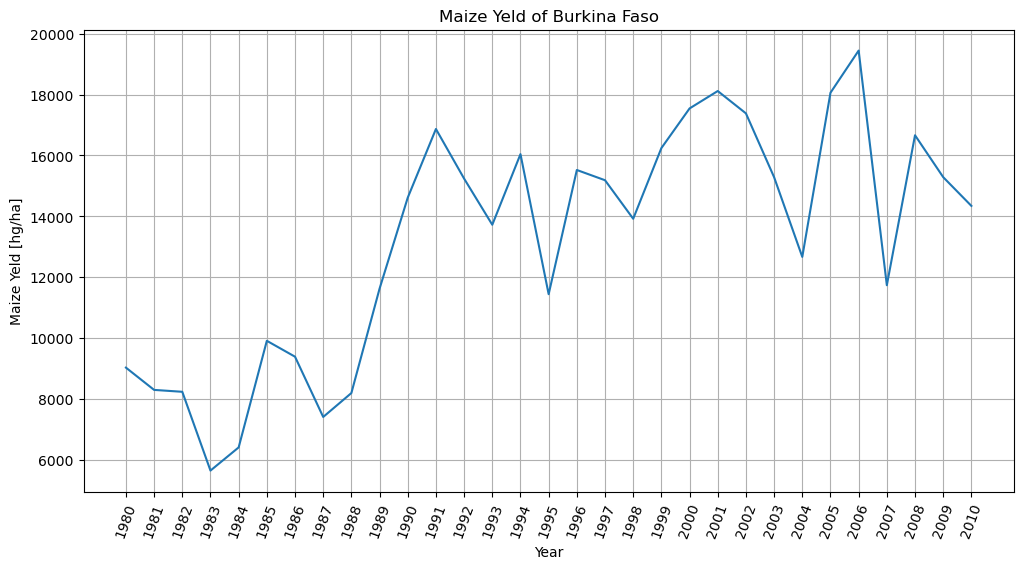

In [9]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax.set_title('Maize Yeld of Burkina Faso')
ax.set_xlabel('Year')
ax.set_ylabel('Maize Yeld [hg/ha]');
ax.set_xticks(crop_yeld_bf_df.index)
ax.set_xticklabels(crop_yeld_bf_df.index, rotation=70)
ax.grid(True, which='both')
plt.plot(crop_yeld_bf_df['Maize [hg/ha]'])

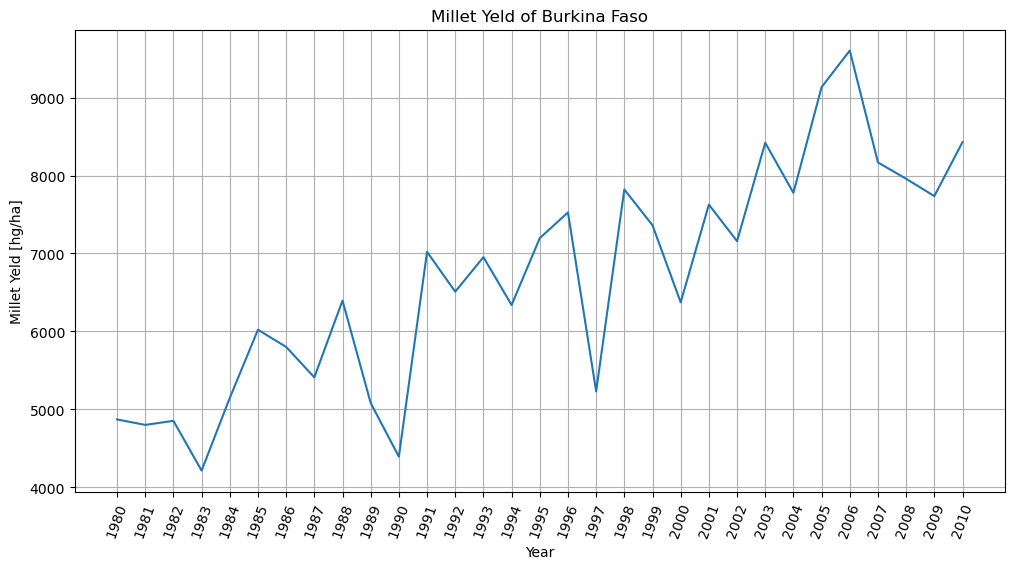

In [10]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax.set_title('Millet Yeld of Burkina Faso')
ax.set_xlabel('Year')
ax.set_ylabel('Millet Yeld [hg/ha]');
ax.set_xticks(crop_yeld_bf_df.index)
ax.set_xticklabels(crop_yeld_bf_df.index, rotation=70)
ax.grid(True, which='both')
plt.plot(crop_yeld_bf_df['Millet [hg/ha]'])

In [10]:
N = crop_yeld_bf_df.shape[0]
mean_maize_bf = crop_yeld_bf_df['Maize [hg/ha]'].sum() / N
print('Mean maize yeld for Burkina Faso: {0:.2f}'.format(mean_maize_bf))

Mean maize yeld for Burkina Faso: 13207.90


In [11]:
max_maize_bf = crop_yeld_bf_df['Maize [hg/ha]'].max() * 1.0
maize_yeld_bf_norm_df = (crop_yeld_bf_df['Maize [hg/ha]'] / max_maize_bf - 0.5) * 2
maize_yeld_bf_norm_df[:3]

1980   -0.071282
1981   -0.146575
1982   -0.152952
Name: Maize [hg/ha], dtype: float64

In [12]:
mean_millet_bf = crop_yeld_bf_df['Millet [hg/ha]'].sum() / N
print('Mean millet yeld for Burkina Faso: {0:.2f}'.format(mean_millet_bf))

Mean millet yeld for Burkina Faso: 6688.29


In [13]:
max_millet_bf = crop_yeld_bf_df['Millet [hg/ha]'].max() * 1.0
millet_yeld_bf_norm_df = (crop_yeld_bf_df['Millet [hg/ha]'] / max_millet_bf - 0.5) * 2
millet_yeld_bf_norm_df[:3]

1980    0.014475
1981   -0.000104
1982    0.010726
Name: Millet [hg/ha], dtype: float64

In [14]:
x_yeld_bf_df = pd.DataFrame({'Millet': millet_yeld_bf_norm_df, 'Maize': maize_yeld_bf_norm_df})
x_yeld_bf_df

,Millet,Maize
1980,0.014475,-0.071282
1981,-0.000104,-0.146575
1982,0.010726,-0.152952
1983,-0.122149,-0.419152
1984,0.071957,-0.340876
1985,0.254191,0.019338
1986,0.208164,-0.034355
1987,0.126939,-0.238017
1988,0.332084,-0.157169
1989,0.058419,0.195536


## Train, validation, and test set
The dataset is divided into a train and validation set and a test set. The train and validation set is then split into a train set and a validation set.

In [ ]:
from sklearn.model_selection import train_test_split

## References
* [Pasini et al. - Influence of Meteo-Climatic Variables and Fertilizer Use on Crop Yelds in the Sahel: A Nonlinear Neural-Network Analysis](https://www.mdpi.com/2225-1154/10/12/193)
* [Pasini - Artificial neural network for small dataset analysis](https://jtd.amegroups.org/article/view/4418/4811)
* [LeCun et al. - Efficient BackProp](https://cseweb.ucsd.edu/classes/wi08/cse253/Handouts/lecun-98b.pdf)
* [Nocedal - Numerical Optimization, 2nd Ed.](https://link.springer.com/book/10.1007/978-0-387-40065-5)
* [Buitinck et al. - API design for machine learning software: experiences from scikit-learn project](https://arxiv.org/abs/1309.0238)